In [1]:
# 일 기온 예측 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드
# 서귀포(189) 일평균 기온분석(2020.1.1~2023.11.16) 데이터 사용
# 데이터 소스: 기상청 기상자료 포털 (https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179)에서 csv로 다운로드

from google.colab import files
uploaded = files.upload()

Saving Temp.xlsx to Temp.xlsx


{'date': DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16'],
              dtype='datetime64[ns]', length=1416, freq='D'), 'temperature': array([ 7. ,  8.7,  9.5, ..., 12. , 13.1, 12.8])}


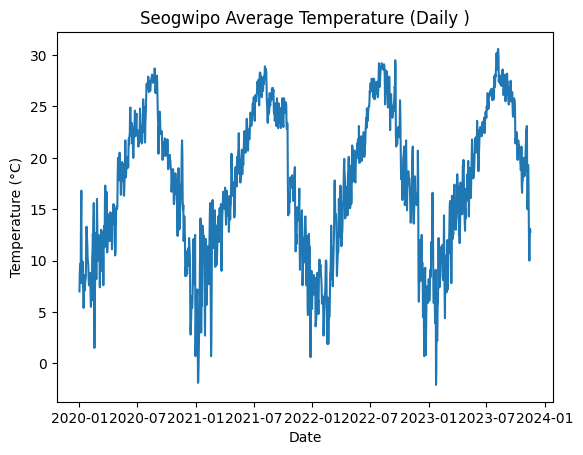

In [3]:
# 업로드한 파일의 이름 추출
file_name = list(uploaded.keys())[0]

# 엑셀 파일 읽어오기
df = pd.read_excel(file_name)

# 수집데이터 열 (예: 평균기온 4열)
target_col_number = 4

# 측정지 선택 (행)
target_col = df.iloc[11:, target_col_number - 1].tolist()


days = len(target_col)
temperature_data = {'date': pd.date_range(start='2020-01-01', periods=days, freq='D'), 'temperature': np.array(target_col)}

print(temperature_data)

weather_df = pd.DataFrame(temperature_data)
weather_df.set_index('date', inplace=True)

# 데이터 시각화
import matplotlib.pyplot as plt

plt.plot(weather_df.index, weather_df['temperature'])
plt.title('Seogwipo Average Temperature (Daily )')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# 데이터 분할 (학습 데이터와 테스트 데이터)
train_size = int(len(weather_df) * 0.8)
train, test = weather_df[:train_size], weather_df[train_size:]

In [4]:
# 데이터 전처리
scaler = MinMaxScaler()
temperature_data_scaled = scaler.fit_transform(np.array(target_col).reshape(-1, 1))

In [5]:
# 시퀀스 데이터 생성 함수
def create_sequence_data(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)

    return torch.tensor(sequences), torch.tensor(labels)

# 데이터를 시퀀스로 변환 (예: 10일 동안의 데이터를 사용하여 예측)
sequence_length = 10
X, y = create_sequence_data(temperature_data_scaled, sequence_length)

# 데이터를 학습용과 테스트용으로 분리
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

<ipython-input-5-5793bb705788>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(sequences), torch.tensor(labels)


In [6]:
# LSTM 모델 정의
class TemperatureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TemperatureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 모델, 손실 함수, 최적화 함수 정의
input_size = 1  # 입력 피처의 수
hidden_size = 50
output_size = 1  # 출력 피처의 수
learning_rate = 0.01
num_epochs = 100

model = TemperatureLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# 학습
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.float())
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0734
Epoch [20/100], Loss: 0.0407
Epoch [30/100], Loss: 0.0298
Epoch [40/100], Loss: 0.0201
Epoch [50/100], Loss: 0.0065
Epoch [60/100], Loss: 0.0057
Epoch [70/100], Loss: 0.0051
Epoch [80/100], Loss: 0.0046
Epoch [90/100], Loss: 0.0046
Epoch [100/100], Loss: 0.0045


In [8]:
# 테스트
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    test_loss = criterion(test_outputs, y_test.float())

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0029


미래 7일간의 기상 데이터 예측:
Day 1: 12.87
Day 2: 12.78
Day 3: 12.67
Day 4: 12.51
Day 5: 12.39
Day 6: 12.33
Day 7: 12.32


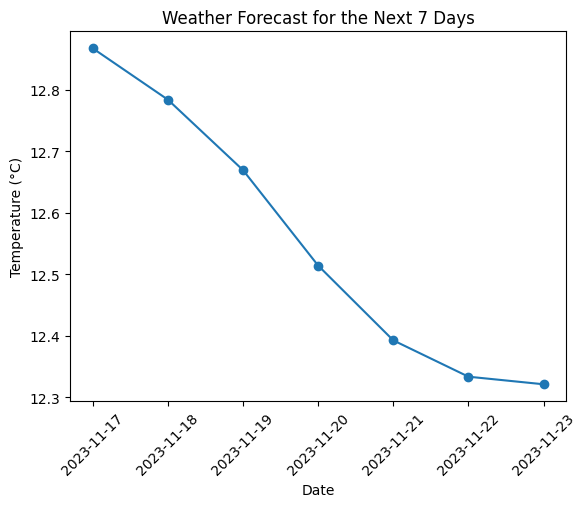

In [36]:
# 미래 7일간의 기상 데이터 예측
model.eval()
with torch.no_grad():
    # 마지막 학습 데이터를 사용하여 미래 7일간의 기상 데이터를 예측
    last_sequence = torch.tensor(temperature_data_scaled[-sequence_length:], dtype=torch.float32).view(1, -1, 1)
    future_predictions = []

    for _ in range(7):
        prediction = model(last_sequence)
        future_predictions.append(prediction.item())
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.view(1, 1, 1)], dim=1)

# 스케일 역변환
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

pred_flat = future_predictions.flatten()

# 결과 출력
print("미래 7일간의 기상 데이터 예측:")
for i, prediction in enumerate(pred_flat, 1):
    print(f"Day {i}: {prediction:.2f}")

# 2023-11-17 부터 예측
from datetime import datetime, timedelta
start_date = datetime(2023, 11, 17)
dates = [start_date + timedelta(days=i) for i in range(len(pred_flat))]

plt.plot(dates, pred_flat , marker='o', linestyle='-')

plt.title('Weather Forecast for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

# #실제값 표시
# plt.scatter(dates, future_predictions, color='red', label='실제값')
# for i, txt in enumerate(future_predictions):
#     plt.annotate(txt, (dates[i], future_predictions[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xticks(rotation=45)  # x축 날짜 눈금이 길어질 경우 각도를 조절하여 가독성 향상

plt.show()